This notebook is part of the `kikuchipy` documentation https://kikuchipy.org.
Links to the documentation won't work from the notebook.

# Pattern matching

Crystal orientations can be determined from experimental EBSD patterns by matching them to simulated patterns of known phases and orientations, see e.g. <cite data-cite="chen2015dictionary">Chen et al. (2015)</cite>, <cite data-cite="nolze2016pattern">Nolze et al. (2016)</cite>, <cite data-cite="foden2019indexing">Foden et al. (2019)</cite>.

In this tutorial, we will perform *dictionary indexing* (DI) using a small Ni EBSD data set and a dynamically simulated Ni master pattern from EMsoft, both of low resolution and found in the [kikuchipy.data](../reference/generated/kikuchipy.data.rst) module.
The pattern dictionary is generated from a uniform grid of orientations with a fixed projection center (PC) followng <cite data-cite="singh2016orientation">Singh and De Graef (2016)</cite>.
The true orientation is likely to fall in between grid points, which means there is always a lower angular accuracy associated with DI.
We can improve upon each solution by letting the orientation deviate from the grid points.
We do this by maximizing the similarity between experimental and simulated patterns using numerical optimization algorithms.
This is here called *orientation refinement*.
We could instead keep the orientations fixed and let the PC parameters deviate from their fixed values used in the dictionary, here called *projection center refinement*.
Finally, we can also refine both at the same time, here called *orientation and projection center refinement*.
The need for orientation or orientation and PC refinement is discussed by e.g. <cite data-cite="singh2017application">Singh et al. (2017)</cite>, <cite data-cite="winkelmann2020refined">Winkelmann et al. (2020)</cite>, and <cite data-cite="pang2020global">Pang et al. (2020)</cite>.

The term *pattern matching* is here used for the combined approach of DI followed by refinement.

Before we can generate a dictionary of simulated patterns, we need a master pattern containing all possible scattering vectors for a candidate phase.
This can be simulated using EMsoft (<cite data-cite="callahan2013dynamical">Callahan and De Graef (2013)</cite> and <cite data-cite="jackson2014h5ebsd">Jackson et al. (2014)</cite>) and then read into kikuchipy.

First, we import libraries

In [1]:
# Exchange inline for notebook or qt5 (from pyqt) for interactive plotting
%matplotlib inline

import tempfile

import matplotlib.pyplot as plt
import numpy as np

import hyperspy.api as hs
import kikuchipy as kp
from orix import sampling, plot, io
from orix.vector import Vector3d


plt.rcParams.update({"figure.facecolor": "w", "font.size": 15})

Load the small experimental nickel test data

In [2]:
# Use kp.load("data.h5") to load your own data
s = kp.data.nickel_ebsd_large(allow_download=True)  # External download
s.remove_static_background()
s.remove_dynamic_background()
# load master pattern
energy = 20
mp = kp.data.nickel_ebsd_master_pattern_small(
    projection="lambert", energy=energy
)
ni = mp.phase
rot = sampling.get_sample_fundamental(
    method="cubochoric", resolution=2.0, point_group=ni.point_group
)
print("Dictionary size: ", rot.shape[0])
det = kp.detectors.EBSDDetector(
    shape=s.axes_manager.signal_shape[::-1],
    pc=[0.4198, 0.2136, 0.5015],
    sample_tilt=70,
)
sim = mp.get_patterns(
    rotations=rot,
    detector=det,
    energy=energy,
    dtype_out=np.float32,
    compute=True,
)
signal_mask = ~kp.filters.Window("circular", det.shape).astype(bool)
p = s.inav[0, 0].data

2023-05-13 08:26:12,186 - numexpr.utils - INFO - Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2023-05-13 08:26:12,187 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.
2023-05-13 08:26:12,535 - numba.cuda.cudadrv.driver - INFO - init


[########################################] | 100% Completed | 100.95 ms
[########################################] | 100% Completed | 403.06 ms
Dictionary size:  100347
[########################################] | 100% Completed | 1.61 ss


Finally, let's use the [pca_dictionary_indexing()](../reference/generated/kikuchipy.signals.EBSD.pca_dictionary_indexing.rst) method to match the simulated patterns to our experimental patterns. Let's keep the best matching orientation alone. The results are returned as a [orix.crystal_map.CrystalMap](https://orix.readthedocs.io/en/stable/reference/generated/orix.crystal_map.CrystalMap.html).

In [8]:
from kikuchipy.indexing.di_indexers import PCAIndexer
indexer = PCAIndexer(
                    datatype='float32',
                    zero_mean=True,
                    unit_var=False,
                    whiten=False,
                    n_components=500,
                )
xmap = s.pca_dictionary_indexing(
    dictionary=sim,
    indexer=indexer,
    keep_n=1,
    n_experimental_per_iteration=4096,
    navigation_mask= None,
    signal_mask = signal_mask
)
xmap


Experiment loop:  50%|█████     | 1/2 [00:01<00:01,  1.35s/it]
                                                              

  Indexing speed: 619.90476 patterns/s, 


Phase   Orientations  Name  Space group  Point group  Proper point group     Color
    0  4125 (100.0%)    ni        Fm-3m         m-3m                 432  tab:blue
Properties: scores, simulation_indices
Scan unit: um

The results can be exported to an HDF5 file re-readable by orix, or an .ang file readable by MTEX and some commercial packages

In [9]:
temp_dir = tempfile.mkdtemp() + "/"
io.save(temp_dir + "ni.h5", xmap)
io.save(temp_dir + "ni.ang", xmap)

### Validate indexing results

With the [orix library](https://orix.readthedocs.io) we can plot inverse pole figures (IPFs), color orientations to produce orientation maps (also called IPF maps), and more.
This is useful to quickly validate our results before processing them further.
If we want to analyze the results in terms of reconstructed grains, textures from orientation density functions, or similar, we have to use other software, like MTEX.

Let's generate an IPF color key and plot it

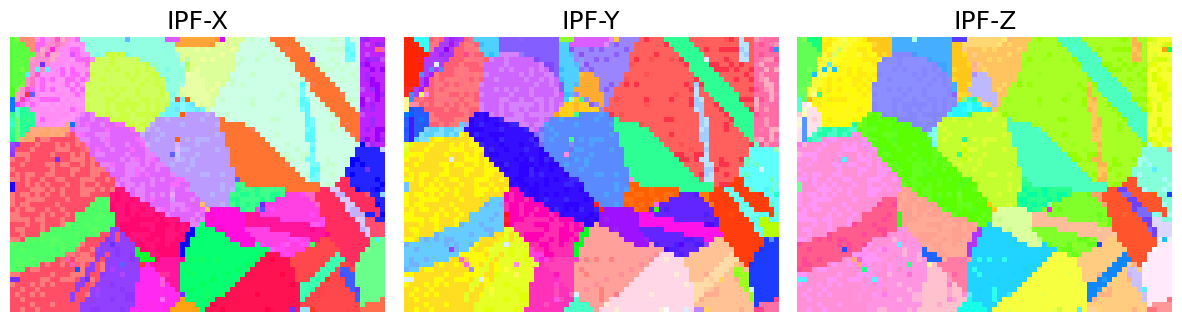

In [10]:
pgm3m = ni.point_group
ckey = plot.IPFColorKeyTSL(pgm3m, direction=Vector3d.xvector())
ori = xmap.orientations
directions = Vector3d(((1, 0, 0), (0, 1, 0), (0, 0, 1)))

fig, axes = plt.subplots(figsize=(15, 5), ncols=3)
for ax, v, title in zip(axes, directions, ("X", "Y", "Z")):
    ckey.direction = v
    rgb = ckey.orientation2color(ori).reshape(xmap.shape + (3,))
    ax.imshow(rgb)
    ax.axis("off")
    ax.set_title(f"IPF-{title}")
fig.subplots_adjust(wspace=0.05)

In [11]:
# Remove files written to disk in this tutorial
import os

os.remove(temp_dir + "ni.h5")
os.remove(temp_dir + "ni.ang")
os.rmdir(temp_dir)